# Partial Dependence Plot (PDP)

## Read and process data

In [1]:
!git clone https://github.com/Abdulrasheed1729/xai.git

Cloning into 'xai'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 121 (delta 48), reused 87 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 21.05 MiB | 13.02 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from itertools import chain, combinations, product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
with open("xai/data/LoanApprovalPrediction.csv", "r") as file:
    data_frame = pd.read_csv(file)
# Remove all rows with nan values
data_frame = data_frame.dropna()

In [4]:
print(len(data_frame.columns))

13


In [5]:
categorical_feature_names= ["Gender", "Married", "Education", "Self_Employed", "Property_Area", "Credit_History", "Dependents"]
continuous_feature_names= ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
drop_column = "Loan_ID" # Not included as the value is unique for each row
label_column = "Loan_Status"

In [6]:
categories_per_feature = [
    sorted(data_frame[col].unique().tolist()) for col in categorical_feature_names]
ohencoder = OneHotEncoder(categories=categories_per_feature)
scaler = StandardScaler()
labelencoder = LabelEncoder()

In [7]:
def preprocess_data(df: pd.DataFrame, continuous_feature_names: list[str], categorical_feature_names: list[str], label_column=str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Parameters:
        df (pd.DataFrame): the data in pandas dataframe format
        continuous_feature_names (list[str]): list of the feature names where the feature is continuous
        categorical_feature_names (list[str]): list of the feature names where the feature is categorical
        label_column (str): name of the label
    Returns:
        tuple[pd.DataFrame, pd.Dataframe]: preprocessed feature values and preprocessed labels
    """
    # Fit data, using a scaler for continuous data, oheencoder for categorical data and a labelencoder for the target values (label)
    continuous_features = scaler.transform(df[continuous_feature_names])
    categorical_features = ohencoder.transform(df[categorical_feature_names]).toarray()
    labels = labelencoder.transform(df[label_column])

    # Convert to tensors and using the available device
    continuous_features = torch.tensor(continuous_features, dtype=torch.float32, device=device)
    categorical_features = torch.tensor(categorical_features, dtype=torch.float32, device=device)
    labels = torch.tensor(labels, dtype=torch.float32, device=device)
    preprocessed_features = torch.hstack((continuous_features, categorical_features))

    return preprocessed_features, labels

In [8]:
df = data_frame.copy(deep=True) # we will use the raw data later and do not want to modify in place
scaler.fit(df[continuous_feature_names])
ohencoder.fit(df[categorical_feature_names])
labelencoder.fit(df[label_column])
preprocessed_data, labels = preprocess_data(df, continuous_feature_names, categorical_feature_names, label_column)

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, labels, random_state=42, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32)

## Create and train model

In [9]:
class Network(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.f1 = nn.Linear(input_dim, 64)
        self.f2 = nn.Linear(64, 1)

    def forward(self, x: torch.Tensor):
        x = F.relu(self.f1(x))
        x = self.f2(x)
        return x

In [10]:
def train_one_epoch(train_loader, model):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X).squeeze(-1)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test).squeeze(-1)
        loss = loss_fn(outputs, y_test)
        preds = torch.sigmoid(outputs)
        accuracy = sum((preds > 0.5) == y_test)/len(y_test)
    return loss, accuracy

In [11]:
input_dim = len(X_train[0])
model = Network(input_dim).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03)

In [12]:
for _ in range(100):
    loss, accuracy = train_one_epoch(train_loader, model)
print("Loss:", loss.item(), "\nAccuracy:", accuracy.item())

Loss: 0.37547656893730164 
Accuracy: 0.8613861203193665


## Partial dependence plots

We want to marginalize over all other features $\boldsymbol{x}_C$ so the function show the relationship between features (or feature) in set $S$:
$$
\hat{f}_S(\boldsymbol{x}_S) = \frac{1}{n}\sum^n_{i=1} \hat{f}(\boldsymbol{x}_S, \boldsymbol{x}_C^{(i)})
$$

First let us consider one categorical feature

In [13]:
def create_modified_df(df: pd.DataFrame, feature: str, values: list) -> [dict[str, pd.DataFrame]]:
    """
    Parameters:
        df (pd.DataFrame): data
        feature (str): name of the feature that should be modified
        values (list): the possible values of the feature
    Returns:
        dict[str, pd.DataFrame]: set of dataframes where the the rows of the feature are set to the same value.
    """
    dfs = {}
    for value in values:
        df.loc[:, feature] = value
        dfs[value] = df.copy(deep=True)
    return dfs

In [14]:
feature_name = "Married"
categories = set(df[feature_name].values.flatten())
mod_dfs = create_modified_df(data_frame.copy(deep=True), feature_name, categories)

print("Original number of data points:", df.shape[0])
print(f"Possible values for the feature {feature_name}: {categories}")
print("Number of dataframes for upsampled data:", len(mod_dfs))
print("Total number of data points:", [sum(len(mod_dfs[_key]) for _key in mod_dfs.keys())][0])

Original number of data points: 505
Possible values for the feature Married: {'Yes', 'No'}
Number of dataframes for upsampled data: 2
Total number of data points: 1010


In [15]:
def get_marginalized_probability(df:pd.DataFrame, continuous_feature_names:list,
                                 categorical_feature_names:list, label_column:str)->float:
    """
    Parameters:
        df (pd.DataFrame): data
        continuous_feature_names (list): names of continuous feaures
        categorical_feature_names (list): names of categorical features
        label_column (str): header of the target column
    Returns:
        float: the mean sigmoid prediction for the dataframe.
    """
    preprocessed_data, labels = preprocess_data(df, continuous_feature_names, categorical_feature_names, label_column)

    outputs = model(preprocessed_data).squeeze(-1)
    preds = torch.sigmoid(outputs)
    return float(preds.mean().item())

In [16]:
probabilities= {}
for category in categories:
    df = mod_dfs[category].copy(deep=True)
    probability = get_marginalized_probability(df, continuous_feature_names, categorical_feature_names, label_column)
    probabilities[category] = probability

In [17]:
print(f"Marginalised probabilities per value of feature {feature_name}:")
print(probabilities)

Marginalised probabilities per value of feature Married:
{'Yes': 0.7166070938110352, 'No': 0.6497240662574768}


## Plot the results

In [18]:
y = probabilities.values()
x = probabilities.keys()

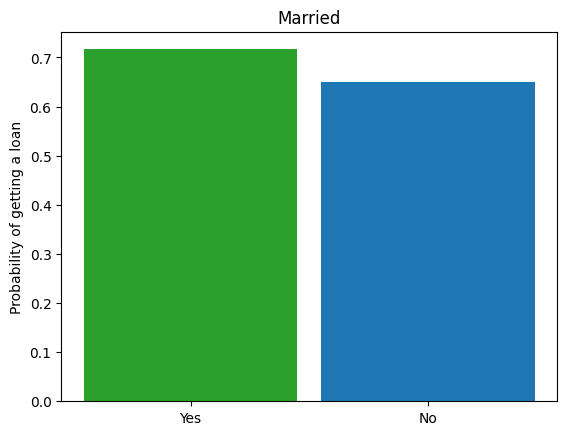

In [19]:
fig, ax = plt.subplots()
#ax.bar(x, y, width=0.9, linewidth=0.7, color=["tab:blue", "tab:green", "tab:orange"]) # property area
ax.bar(x, y, width=0.9, linewidth=0.7, color=["tab:green", "tab:blue"]) # married
plt.title(feature_name)
plt.ylabel("Probability of getting a loan")
plt.show()

## Categorical features

In [20]:
plot_data = []
for feature_name in categorical_feature_names:
    df = data_frame.copy(deep=True)
    categories = set(df[feature_name].values.flatten())
    mod_dfs = create_modified_df(df, feature_name, categories)

    probabilities = {}
    for category in categories:
        probability = get_marginalized_probability(mod_dfs[category], continuous_feature_names, categorical_feature_names, label_column)
        probabilities[category] = probability

    y = probabilities.values()
    x = probabilities.keys()
    plot_data.append((feature_name, x,y))

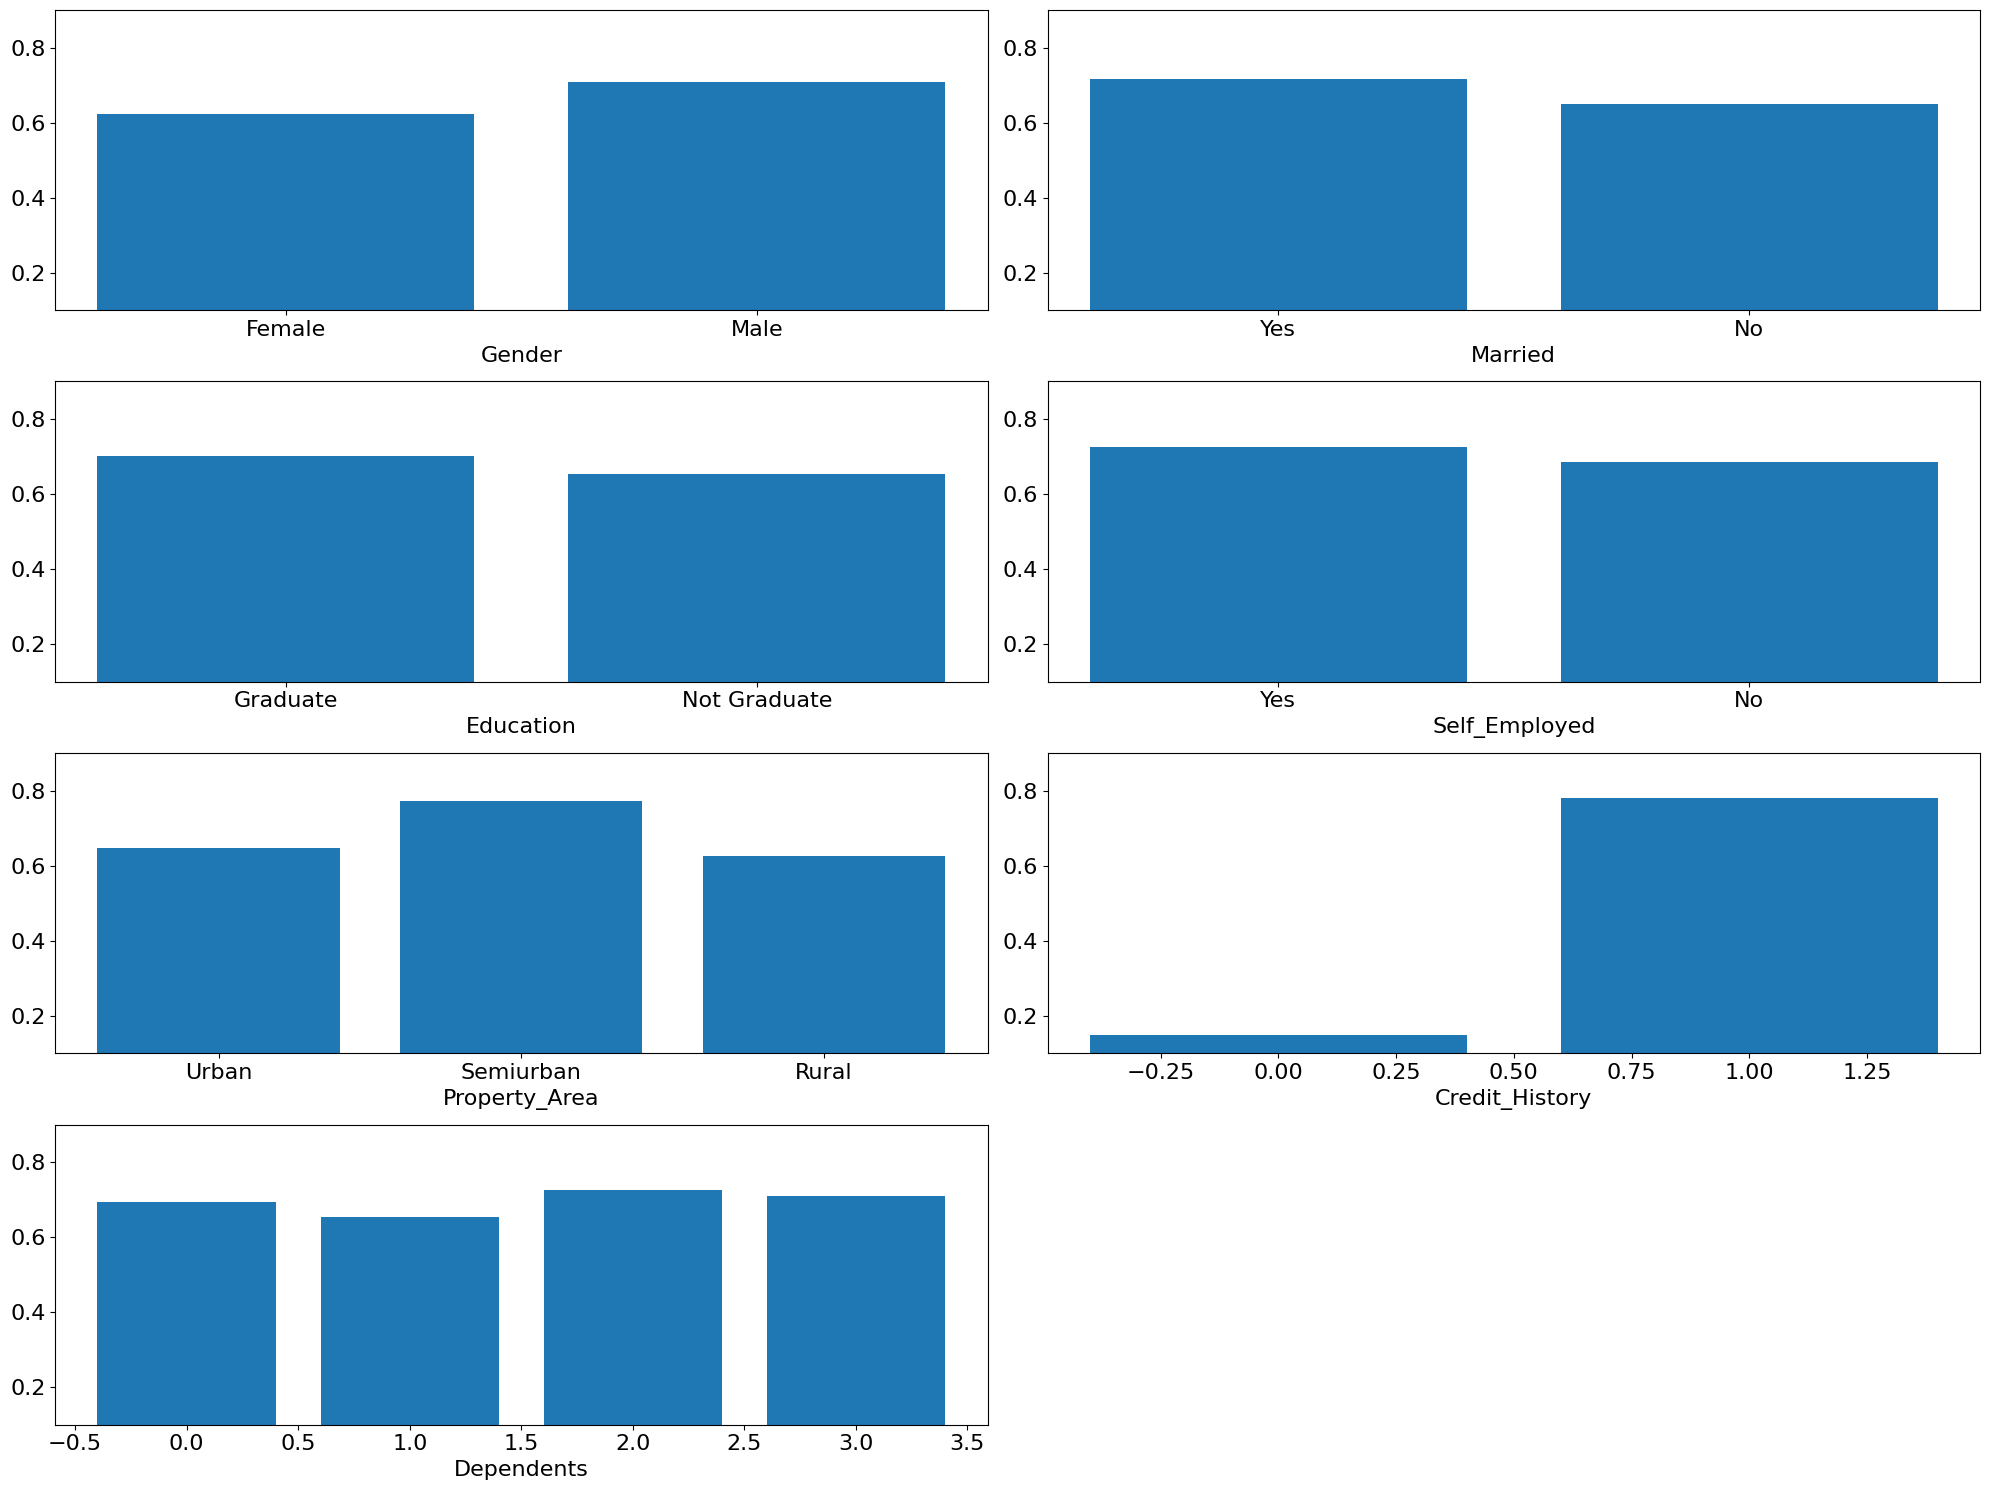

In [21]:
data = plot_data.copy()  # Just to be safe

ncols = 2
N = len(data)
nrows = math.ceil(N / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

# Ensure axs is 2D
if nrows == 1 and ncols == 1:
    axs = [[axs]]
elif nrows == 1:
    axs = [axs]
elif ncols == 1:
    axs = [[ax] for ax in axs]

# Plot each feature as a bar chart
for i, (feature, x, y) in enumerate(data):
    r, c = divmod(i, ncols)
    ax = axs[r][c]
    ax.bar(x, y)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel(feature, fontsize=16)
    ax.set_ylim(0.1, 0.9)  # Optional: adjust as needed


# Hide unused subplots
for j in range(N, nrows * ncols):
    r, c = divmod(j, ncols)
    axs[r][c].axis("off")

fig.tight_layout()
plt.show()


## Continuous features

In [22]:
#feature = "LoanAmount"
feature = "CoapplicantIncome"

In [54]:
plot_data = dict()
n = 10

for feature_name in continuous_feature_names:
    df = data_frame.copy(deep=True)
    lower_bound = np.quantile(df[feature_name], 0.000000001)
    upper_bound = np.quantile(df[feature_name], 0.999999999)
    values = np.linspace(lower_bound, upper_bound, n, dtype=int)
    #values = np.linspace(df[feature_name].min(), df[feature_name].max(), n, dtype=int)
    mod_dfs = create_modified_df(df, feature_name, values)

    probabilities = []
    for value in values:
        probability = get_marginalized_probability(mod_dfs[value].copy(deep=True),
                                                   continuous_feature_names, categorical_feature_names, label_column)
        probabilities.append(probability)

    plot_data[feature_name] = (values, probabilities)

In [55]:
print(f"Interval values for feature {feature}: {plot_data[feature][0]}")
print(f"Corresponding marginalized probabilities: {plot_data[feature][1]}")

Interval values for feature CoapplicantIncome: [    0  3759  7519 11278 15038 18798 22557 26317 30077 33836]
Corresponding marginalized probabilities: [0.6812028288841248, 0.7151671051979065, 0.6906607151031494, 0.6336717009544373, 0.5607153177261353, 0.47955846786499023, 0.39645305275917053, 0.31786590814590454, 0.24806664884090424, 0.18945026397705078]


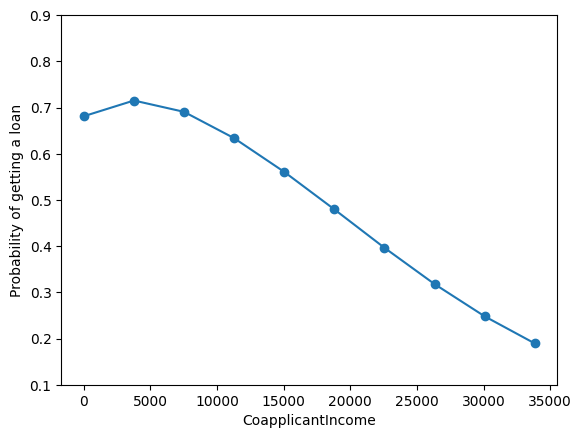

In [56]:
x, y = plot_data[feature]
plt.plot(x, y)
plt.scatter(x, y)
plt.ylim([0.1, 0.9])
plt.xlabel(feature)
plt.ylabel("Probability of getting a loan")
plt.show()

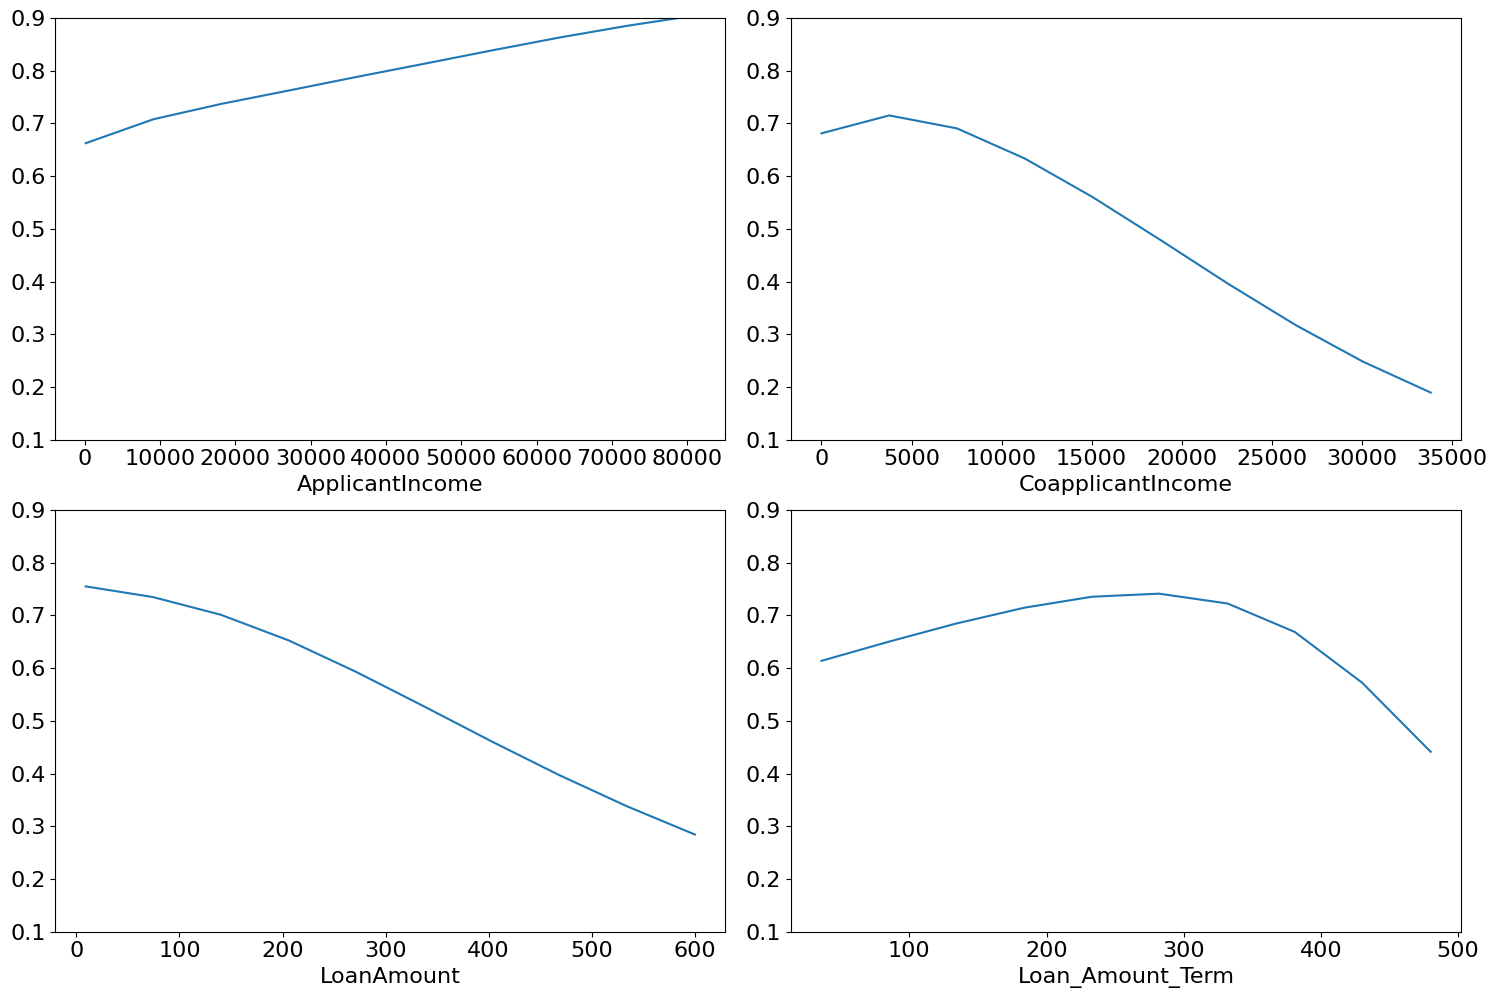

In [57]:
data = plot_data.copy()
ncols=2
figsize=(15,10)
sharex=False
sharey=False

keys = list(data.keys())
N = len(keys)
nrows = math.ceil(N / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey)
# Ensure axs is 2D for consistent indexing
if nrows == 1 and ncols == 1:
    axs = [[axs]]
elif nrows == 1:
    axs = [axs]
elif ncols == 1:
    axs = [[ax] for ax in axs]

# Plot each series
for i, key in enumerate(keys):
    r, c = divmod(i, ncols)
    ax = axs[r][c]
    x, y = data[key]
    ax.plot(x, y)
    ax.set_xlabel(str(key), fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    #ax.grid(True, alpha=0.3)
    ax.set_ylim(0.1, 0.9)

# Turn off any unused axes
for j in range(N, nrows * ncols):
    r, c = divmod(j, ncols)
    axs[r][c].axis("off")

# Optional common labels
#fig.supylabel("Probability of getting a loan")
fig.tight_layout()

## 3D plot

In [ ]:
def powerset(iterable, n: int = 2):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    comb = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    return [list(x) for x in comb if len(x) == n]

In [ ]:
def create_modified_dfs_2d(df: pd.DataFrame, feature1: str, feature2: str, grid_points: np.ndarray) -> list[pd.DataFrame]:
    """
    For each (val1, val2) in grid_points, return a DataFrame where:
    - feature1 is set to val1
    - feature2 is set to val2
    Returns:
        List of DataFrames (one for each point in the grid).
    """
    modified_dfs = dict()
    for val1, val2 in grid_points:
        df_mod = df.copy(deep=True)
        df_mod[feature1] = val1
        df_mod[feature2] = val2
        modified_dfs[val1, val2] = df_mod
    return modified_dfs

In [ ]:
def get_marginalized_probability_2d(
    df: pd.DataFrame,
    feature1: str,
    value1,
    feature2: str,
    value2,
    values1: list,
    values2: list,
) -> float:
    """
    Calculates marginalized probability when both feature1=value1 and feature2=value2.
    """
    #? num_rows = df.shape[0]

    # Set both feature values across the entire dataset
    df = df.copy(deep=True)
    df[feature1] = value1
    df[feature2] = value2

    # Preprocess (custom function)
    preprocessed_data, labels = preprocess_data(
        df,
        continuous_feature_names=continuous_feature_names,
        categorical_feature_names=categorical_feature_names,
        label_column=label_column
    )

    # Model predictions
    outputs = model(preprocessed_data).squeeze(-1)
    preds = torch.sigmoid(outputs)

    return float(preds.mean().item())


In [ ]:
plot_data = dict()
n = 10

feature_names = ["ApplicantIncome", "LoanAmount"]
for (feature_name_1, feature_name_2) in powerset(feature_names, n=2):
    df = data_frame.copy(deep=True)
    # First we drop rows for the feature values that is nan
    df = df.dropna(subset=[feature_name_1, feature_name_2])

    is_cat_1 = feature_name_1 in categorical_feature_names
    is_cat_2 = feature_name_2 in categorical_feature_names

    if is_cat_1:
        values_1 = list(set(df[feature_name_1].values.flatten()))
    else:
        lb1 = np.quantile(df[feature_name_1], 0.005)
        ub1 = np.quantile(df[feature_name_1], 0.995)
        values_1 = np.linspace(lb1, ub1, n, dtype=int)

    if is_cat_2:
        values_2 = list(set(df[feature_name_2].values.flatten()))
    else:
        lb2 = np.quantile(df[feature_name_2], 0.005)
        ub2 = np.quantile(df[feature_name_2], 0.995)
        values_2 = np.linspace(lb2, ub2, n, dtype=int)

    grid_1, grid_2 = np.meshgrid(values_1, values_2)
    grid_points = list(product(grid_1.ravel(), grid_2.ravel()))

    mod_dfs = create_modified_dfs_2d(df, feature_name_1, feature_name_2, grid_points)

    probabilities = []
    vals1 = []
    vals2 = []
    for (val1, val2), mod_df in mod_dfs.items():
        probability = get_marginalized_probability_2d(mod_df.copy(deep=True), feature_name_1, val1, feature_name_2, val2, values_1, values_2)
        vals1.append(val1)
        vals2.append(val2)
        probabilities.append(probability)

    n, m = grid_1.shape
    vals1_grid = np.array(vals1).reshape(n, m)
    vals2_grid = np.array(vals2).reshape(n, m)
    probs_grid = np.array(probabilities).reshape(n, m)

    plot_data[(feature_name_1, feature_name_2)] = (vals1_grid, vals2_grid, probs_grid)

In [ ]:
def encode_categories(arr):
    """Returns encoded numeric array + label mapping"""
    unique_vals = sorted(set(arr.ravel()))
    label_map = {val: i for i, val in enumerate(unique_vals)}
    encoded = np.vectorize(label_map.get)(arr)
    return encoded, label_map

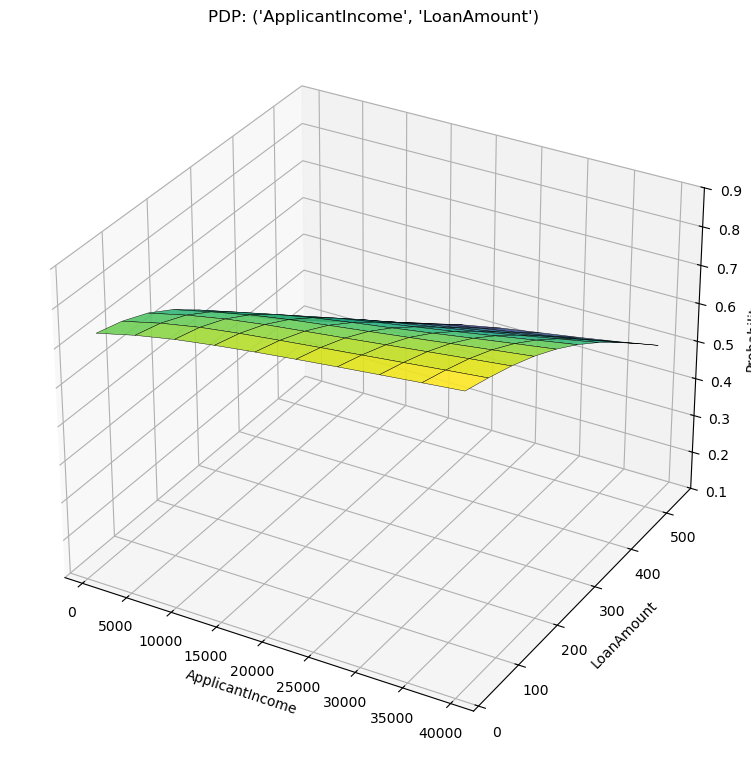

In [ ]:
data = plot_data.copy()
ncols = 2
figsize = (15, 10)

keys = list(data.keys())
N = len(keys)
nrows = math.ceil(N / ncols)

fig = plt.figure(figsize=figsize)

# Create a grid of 3D subplots manually
for i, key in enumerate(keys):
    row, col = divmod(i, ncols)
    ax = fig.add_subplot(nrows, ncols, i + 1, projection='3d')

    X, Y, Z = data[key]  # Each is (n, m)
    if X.dtype.kind in {"U"}:
        X, x_labels = encode_categories(X)
        ax.set_xticks(list(x_labels.values()))
        ax.set_xticklabels(list(x_labels.keys()))
    if Y.dtype.kind in {"U"}:
        Y, y_labels = encode_categories(Y)
        ax.set_yticks(list(y_labels.values()))
        ax.set_yticklabels(list(y_labels.keys()))
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.3, alpha=0.9)

    # Axis labels
    ax.set_xlabel(str(key[0]))
    ax.set_ylabel(str(key[1]))

    ax.set_zlabel("Probability")
    ax.set_title(f"PDP: {key}")
    ax.set_zlim(0.1, 0.9)

# Optional: adjust layout
fig.tight_layout()
plt.show()